# Regression
Шпорта Данило ТШІ-21

## Етап 1

> Завдання: На основі сирих даних підготувати регресійні моделі: KNN,
Linear Regression та її модифікації, дерева рішень. Зафіксувати та
інтерпретувати отримані результати. Сформулювати припущення про те,
чому були отримані такі результати і як їх покращити.

Імпортуємо необхідні бібліотеки

In [912]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Завантажимо набір даних

In [ ]:
df = pd.read_csv('flat_2_en.csv', sep=';', decimal=',')

Виведемо перші десять записів для аналізу





In [ ]:
df.head(10)

,Cart_Number,Rooms_Number,Object_Type,Object_Type_ID,Settlement,Settlement_ID,District,District_Id,Street,Street_Id,...,Value_abs,Value_m,Balcon_Num,Sost,Sost_ID,Clozet,Clozet_ID,lat,Long,Date_Create
0,10083994,1,Typical,2,Novosibirsk,1,Pervomajskij,8,Odoevskogo,1143,...,1340000,60909.091,0,Excellent,6,Combined,8,54.937100,83.101100,2014-04-21 11:24:39.767
1,10015724,1,Improved layout,3,Novosibirsk,1,Dzerzhinskij,1,Adriena Lezhena,964,...,3250000,76112.412,0,Good,2,Combined,8,55.043400,82.982200,2014-12-19 17:41:03.790
2,10014604,1,Typical,2,Novosibirsk,1,Dzerzhinskij,1,Borisa Bogatkova,349,...,2150000,71906.355,0,Satisfactory,7,Combined,8,55.040500,82.980100,2013-04-26 09:48:05.307
3,20094604,2,Typical,2,Novosibirsk,1,Sovetskij,9,Lesosechnaja,980,...,2300000,49676.026,1,NaN,0,Separated,9,54.890200,83.080500,2017-07-26 12:16:17.380
4,30075897,3,Improved layout,3,Novosibirsk,1,Oktjabr'skij,7,Garanina,495,...,2950000,44696.970,0,Good,2,Separated,9,55.028800,82.970300,2016-06-06 15:35:46.470
5,30092911,3,Typical,2,Novosibirsk,1,Sovetskij,9,Lesosechnaja,980,...,2800000,47457.627,1,Good,2,Separated,9,54.890100,83.077100,2016-08-29 09:10:39.750
6,10092501,1,Improved layout,3,Novosibirsk,1,Sovetskij,9,Ekvatornaja,1835,...,3180000,67659.574,0,Euro-renovation,5,Combined,8,54.888200,83.096400,2015-10-19 17:32:43.673
7,30093100,3,Improved layout,3,Novosibirsk,1,Sovetskij,9,Ekvatornaja,1835,...,3800000,59375.000,0,Excellent,6,Separated,9,54.888600,83.100500,2016-10-28 14:51:28.323
8,20076413,2,Typical,2,Novosibirsk,1,Oktjabr'skij,7,Borisa Bogatkova,348,...,3000000,65217.391,1,Good,2,Separated,9,55.032562,82.976467,2014-08-21 14:13:07.017
9,20076452,2,Typical,2,Novosibirsk,1,Oktjabr'skij,7,Borisa Bogatkova,348,...,2800000,60085.837,1,Good,2,Separated,9,55.033600,82.975800,2014-08-25 10:24:21.580


Виведемо назви стовпців з заначенням типу даних, кількості унікальних значень та кількості null значень для аналізу

In [ ]:
def column_metrix(df):
  column_metrix = pd.DataFrame({
      'Unique Values Count |': df.nunique(),
      'Null Values Count |': df.isnull().sum(),
      'Data Type': df.dtypes
  })
  print(column_metrix)

In [ ]:
column_metrix(df)

                Unique Values Count |  Null Values Count | Data Type
Cart_Number                     32440                    0     int64
Rooms_Number                        4                    0     int64
Object_Type                        25                    0    object
Object_Type_ID                     26                    0     int64
Settlement                         85                    0    object
Settlement_ID                      87                    0     int64
District                           24                    0    object
District_Id                        24                    0     int64
Street                            666                    0    object
Street_Id                         913                    0     int64
House_Number                     1095                   17    object
Metro                              15                 1904    object
Metro_ID                           16                    0     int64
Metro_m                          2

Так як на цьому етапі треба оаперувати сирими даними, то все що ми зробимо стосовно обробки даних - це:
- Преобразуємо стовпець дати залишивши тільки рік (вважаю що місяць, день і тим паче час не є важливими). Якщо цього не зробити то не вистачить RAM для навчання, так як після one-hot encoding виникне забагато стовпців.
- Виконаємо one-hot encoding для всіх категоріальних даних

Преобразуємо дату

In [ ]:
df['Date_Create'] = pd.to_datetime(df['Date_Create'], errors='coerce').dt.year
df['Date_Create'] = df['Date_Create'].astype(str)

Виконаємо one-hot encoding

In [ ]:
df = pd.get_dummies(df, drop_first=True)

Сформуємо набори тренувальних та тестових даних. Цільова змінна - повна ціна

In [ ]:
X = df.drop(columns=['Value_abs'])
y = df['Value_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

Для оцінки моделей використаємо такі метрики:
- Mean Absolute Error (MAE) - Показує середню абсолютну різницю між передбаченими та реальними значеннями. Дану метрику легко інтерпретувати так як вона напряму показує середній розмір помилки у прогнозі в тих же одиницях вимірювання, що й цільова змінна.
- Root Mean Squared Error (RMSE) - Корінь із середнього квадрата помилок.Також вираховує масштаб помилок в тих же одиницях вимірювання, що й цільова змінна. Є чутливою до викидів, допоможе оцінити їх вплив.
- Coefficient of Determination (R^2) - показує, яку частку варіації цільової змінної модель змогла пояснити. Найзручніша для оцінки загальної ефективності моделі. Значення від мінус нескінченності до 1, чим ближча до 1 тим краще модель.


Також виведемо графік що ілюструє відхилення отриманої ціни від очікуваної для наглядності.

In [567]:
def evaluate_model_with_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2, predictions

Виконаємо тренування та оцінку моделей

In [568]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}
def train_and_evaluate():
  results = []
  for model_name, model in models.items():
      model.fit(X_train, y_train)
      mae, rmse, r2, predictions = evaluate_model_with_metrics(model, X_test, y_test)
      results.append({
          'Model': model_name,
          'MAE': mae,
          'RMSE': rmse,
          'R2': r2
      })

      plt.figure(figsize=(8, 6))
      plt.scatter(y_test/1e6, predictions/1e6, alpha=0.6)
      plt.plot([y_test.min()/1e6, y_test.max()/1e6], [y_test.min()/1e6, y_test.max()/1e6], '--r', linewidth=2)
      plt.title(f'{model_name}: Expected vs Predicted Prices')
      plt.xlabel('Expected Prices')
      plt.ylabel('Predicted Prices')
      plt.grid(True)
      plt.show()

  results_df = pd.DataFrame(results)
  print("\nResults:")
  print(results_df)

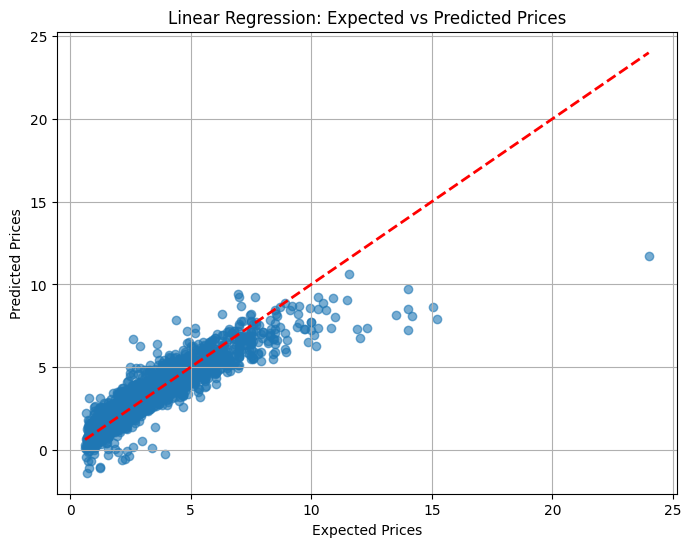

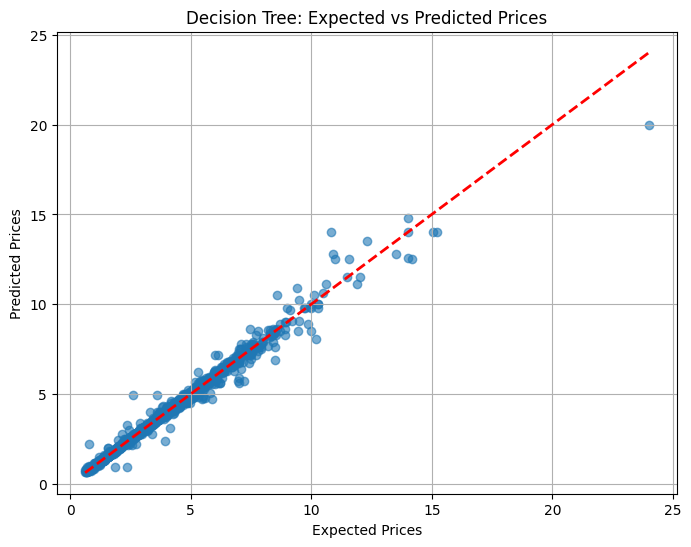

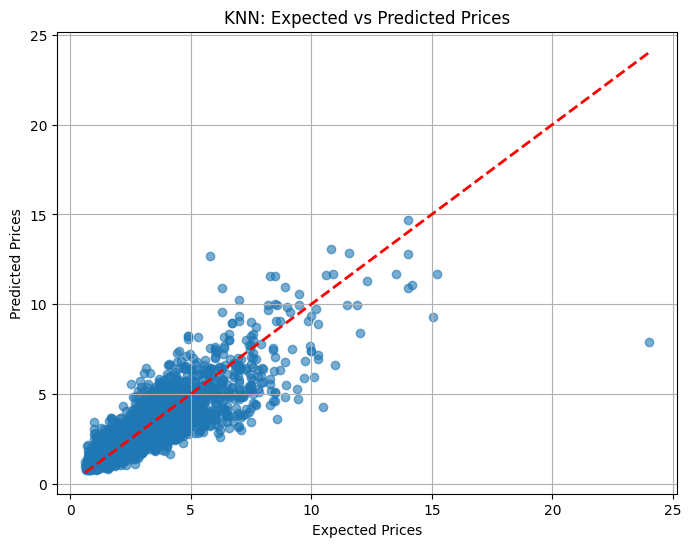


Results:
               Model            MAE           RMSE        R2
0  Linear Regression  282010.807755  473479.490333  0.854658
1      Decision Tree   27404.315769  110301.945642  0.992112
2                KNN  367593.153275  613327.218767  0.756122


In [ ]:
train_and_evaluate()

Як можна побачити з графіків та значень R2, моделі показали відмінні результати, але це не є добре (🙂). В даному випадку результат зумовлений наявністю витоку даних. Значення Value_m є лінійною похідною від значення Value_abs, так як Value_abs = Value_m * Space_Total (таж є в наборі даних).

Проведемо тест. Запустисо тренування та оцінку попередньо видаливши значення Value_m.

In [ ]:
X = df.drop(columns=['Value_abs', 'Value_m'])
y = df['Value_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

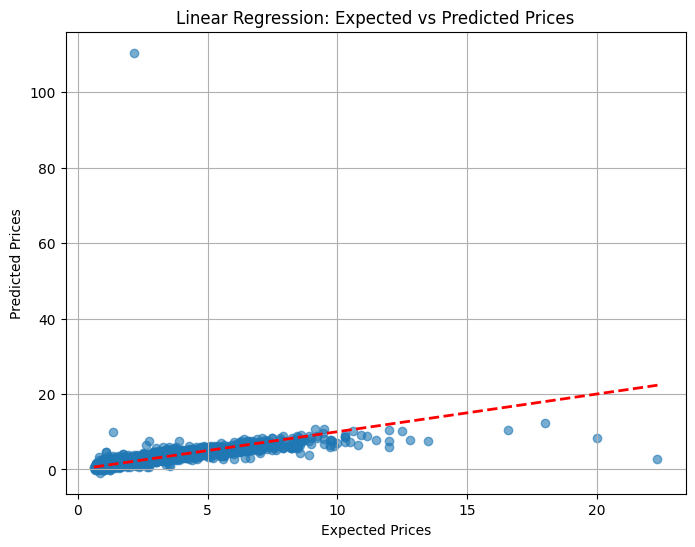

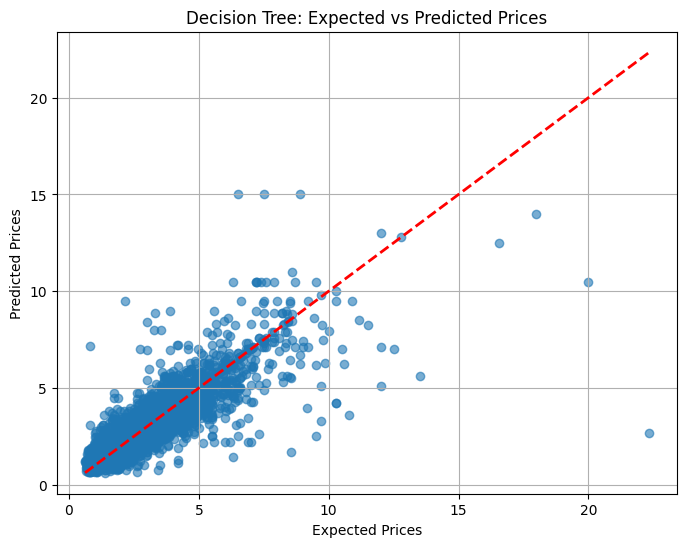

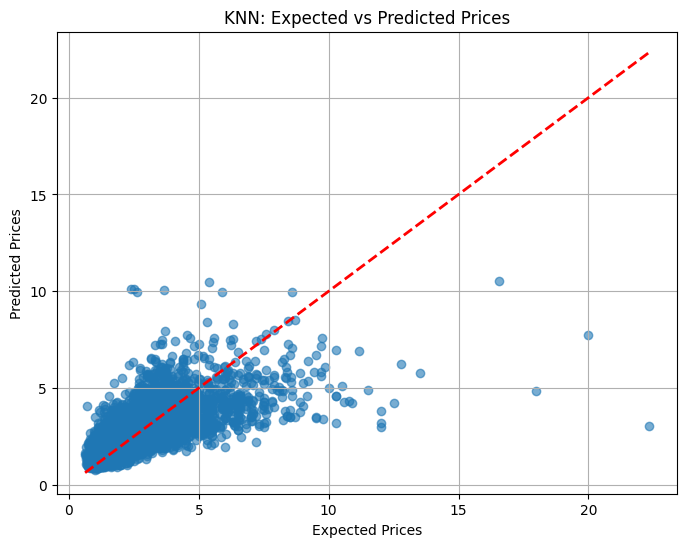


Results:
               Model            MAE          RMSE        R2
0  Linear Regression  305518.631510  1.180084e+06  0.091137
1      Decision Tree  311164.575882  6.173162e+05  0.751293
2                KNN  521852.141723  8.794961e+05  0.495175


In [ ]:
train_and_evaluate()

Як бачимо результат кардинально змінився.


###Висновки
За співвідношенням MAE та RMSE можем зробити висновок, що в даних присутні викиди.

Найгірше себе проявила лінійна регресія. Погана робота лвнвйної регресії пов'язана з:
- Наявність викидів (дуже чутлива)
- Відсутністю нормлізації даних
- Наявністю дублюючих ознак (наприклад Street Stree_ID)
- Наявність шуму (Cart_Number)

KNN показав себе краще, проте теж має поганий результат. Для покращення вимагає:
- Усунення викидів
- Усунення шумів
- Нормалізацію даних
- Зменьшення розмірності
- Усунення нерелевантних ознак

Дерево рішень показало чудовий результат так як є стійким до різниці масштабів, наявності нерелевантних ознак, високої розмірності даних. Проте все ще можна спроьувати покращити його результат за допомогою:
- Зменшення розмірності (для уникнення надмірного розгалуження дерева)
- Обробки пропущених значень
- Вилучення викидів

## Етап 2
> Завдання: Підготувати дані до моделювання (зробити необхідні
перетворення даних, виконати роботу з пропусками та аномальними
спостереженнями). Зробити звіт, в якому обґрунтувати доцільність
проведених маніпуляцій (чому саме ці перетворення були використані,
обґрунтувати вибір інструментів та методів маніпуляцій з даними тощо)



Завантажимо дані

In [1204]:
df = pd.read_csv('flat_2_en.csv', sep=';', decimal=',')

Виведемо перші десять записів для аналізу

In [1205]:
df.head(10)

,Cart_Number,Rooms_Number,Object_Type,Object_Type_ID,Settlement,Settlement_ID,District,District_Id,Street,Street_Id,...,Value_abs,Value_m,Balcon_Num,Sost,Sost_ID,Clozet,Clozet_ID,lat,Long,Date_Create
0,10083994,1,Typical,2,Novosibirsk,1,Pervomajskij,8,Odoevskogo,1143,...,1340000,60909.091,0,Excellent,6,Combined,8,54.937100,83.101100,2014-04-21 11:24:39.767
1,10015724,1,Improved layout,3,Novosibirsk,1,Dzerzhinskij,1,Adriena Lezhena,964,...,3250000,76112.412,0,Good,2,Combined,8,55.043400,82.982200,2014-12-19 17:41:03.790
2,10014604,1,Typical,2,Novosibirsk,1,Dzerzhinskij,1,Borisa Bogatkova,349,...,2150000,71906.355,0,Satisfactory,7,Combined,8,55.040500,82.980100,2013-04-26 09:48:05.307
3,20094604,2,Typical,2,Novosibirsk,1,Sovetskij,9,Lesosechnaja,980,...,2300000,49676.026,1,NaN,0,Separated,9,54.890200,83.080500,2017-07-26 12:16:17.380
4,30075897,3,Improved layout,3,Novosibirsk,1,Oktjabr'skij,7,Garanina,495,...,2950000,44696.970,0,Good,2,Separated,9,55.028800,82.970300,2016-06-06 15:35:46.470
5,30092911,3,Typical,2,Novosibirsk,1,Sovetskij,9,Lesosechnaja,980,...,2800000,47457.627,1,Good,2,Separated,9,54.890100,83.077100,2016-08-29 09:10:39.750
6,10092501,1,Improved layout,3,Novosibirsk,1,Sovetskij,9,Ekvatornaja,1835,...,3180000,67659.574,0,Euro-renovation,5,Combined,8,54.888200,83.096400,2015-10-19 17:32:43.673
7,30093100,3,Improved layout,3,Novosibirsk,1,Sovetskij,9,Ekvatornaja,1835,...,3800000,59375.000,0,Excellent,6,Separated,9,54.888600,83.100500,2016-10-28 14:51:28.323
8,20076413,2,Typical,2,Novosibirsk,1,Oktjabr'skij,7,Borisa Bogatkova,348,...,3000000,65217.391,1,Good,2,Separated,9,55.032562,82.976467,2014-08-21 14:13:07.017
9,20076452,2,Typical,2,Novosibirsk,1,Oktjabr'skij,7,Borisa Bogatkova,348,...,2800000,60085.837,1,Good,2,Separated,9,55.033600,82.975800,2014-08-25 10:24:21.580


Виведемо назви стовпців з заначенням типу даних, кількості унікальних значень та кількості null значень для аналізу

In [1206]:
column_metrix(df)

                Unique Values Count |  Null Values Count | Data Type
Cart_Number                     32440                    0     int64
Rooms_Number                        4                    0     int64
Object_Type                        25                    0    object
Object_Type_ID                     26                    0     int64
Settlement                         85                    0    object
Settlement_ID                      87                    0     int64
District                           24                    0    object
District_Id                        24                    0     int64
Street                            666                    0    object
Street_Id                         913                    0     int64
House_Number                     1095                   17    object
Metro                              15                 1904    object
Metro_ID                           16                    0     int64
Metro_m                          2

Одразу видалимо очевидно непотрібні стовпці:
- Cart_Number - є звичайним ID, не несе інформації
- Всі поля з _ID - є дублікатом відповідних значень без _ID

In [1207]:
df = df.drop(columns=["Cart_Number"])
df = df.loc[:, ~df.columns.str.contains('_ID', case=False)]

Загалом номер будинку описує ціну квартири, але тільки у зв'язці з вулицею. Також тут явно не достатньо даних, щоб скласти статистику по конкретних будинках, тож видалимо цю ознаку.

In [1208]:
df = df.drop(columns=["House_Number"])

Заповнимо всі null значення для категоріальних стовпців значенням "Unknown"

In [1209]:
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').fillna("Unknown")

Дослідимо розподіл записів по унікальних значеннях категоріальних полів

In [1210]:
def explore_categorial_distribution(column):
  value_counts = df[column].value_counts()
  value_counts_normalized = df[column].value_counts(normalize=True)

  result = pd.DataFrame({
      column: value_counts.index,
      'Count_Normalized': value_counts_normalized.values,
      'Count': value_counts.values
  }).reset_index(drop=True)

  print(result)

Дослідимо розподіл по містах

In [1211]:
explore_categorial_distribution('Settlement')

         Settlement  Count_Normalized  Count
0       Novosibirsk          0.921018  32103
1            Berdsk          0.028317    987
2               Ob'          0.007201    251
3           Iskitim          0.007000    244
4        Krasnoobsk          0.006685    233
..              ...               ...    ...
80          Krahal'          0.000029      1
81            Novyj          0.000029      1
82         Kubovaja          0.000029      1
83  Verh-Mil'tjushi          0.000029      1
84        Vorob'evo          0.000029      1

[85 rows x 3 columns]


Як бачимо ми бачимо 92% (!!!) всіх записів стосуються одного міста. На мою думку є сенс змінити специфіку датасету з оцінки вартості житла загалом в оцінку вартості житла в конкретному місті. Відповідно видалимо всі записи що не стосуються цього міста та видалимо стовпець Settlement.

In [1212]:
df = df[df['Settlement'] == 'Novosibirsk']
df = df.drop(columns=['Settlement'])

Унікальних вулиць в датасеті доволі багато, дослідимо розподіл записів по вулцях.

In [1213]:
street_counts = df['Street'].value_counts()
top_20_streets = street_counts.head(20)
print(top_20_streets)

Street
Zorge                     835
Odoevskogo                808
Viktora Usa               799
Vysotskogo                786
Petuhova                  774
Borisa Bogatkova          686
Tat'jany Snezhinoj        673
Vybornaja                 595
Gorskij mikrorajon        572
Kropotkina                520
Tvardovskogo              474
Dusi Koval'chuk           438
Adriena Lezhena           428
Gogolja                   359
Krasnyj prospekt          348
Titova                    346
Esenina                   321
Nemirovicha-Danchenko     319
Dzerzhinskogo prospekt    280
Vatutina                  278
Name: count, dtype: int64


In [1214]:
category_counts = df['Street'].value_counts()
print(category_counts.describe())

count    524.000000
mean      61.265267
std      115.193728
min        1.000000
25%        5.000000
50%       20.000000
75%       70.000000
max      835.000000
Name: count, dtype: float64


Для зниження розмірності об'єднаємо рідкісі вулиці у Other. Пороговим значенням оберемо медіану.

In [1215]:
def unite_to_other(column, threshhold):
    value_counts = df[column].value_counts()
    rare_values = value_counts[value_counts < threshhold].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_values else x)
    print(df[column].value_counts())

In [1216]:
unite_to_other('Street', 20)

Street
Other               1624
Zorge                835
Odoevskogo           808
Viktora Usa          799
Vysotskogo           786
                    ... 
Trudovaja             21
Krasnyj Fakel         20
Borovaja Partija      20
Poljakova             20
Jadrintsevskaja       20
Name: count, Length: 265, dtype: int64


Object_Type

In [1217]:
explore_categorial_distribution('Object_Type')

                 Object_Type  Count_Normalized  Count
0            Improved layout          0.500607  16071
1               Khrushchevka          0.215027   6903
2                    Typical          0.194468   6243
3                  Full size          0.043329   1391
4                   Low-rise          0.017226    553
5               Small family          0.014952    480
6                 Apartments          0.006355    204
7                  Dormitory          0.003364    108
8                      Elite          0.002399     77
9        Individual planning          0.001121     36
10           Corridor system          0.000249      8
11                   Parking          0.000187      6
12               Small-sized          0.000156      5
13                 Penthouse          0.000125      4
14  Non-residential premises          0.000125      4
15                 1/2 house          0.000093      3
16                 Townhouse          0.000093      3
17                     Other

Я б об'єднав в Other все що меньше 0.1% проте Individual planning це буквально тотожно до Other тож об'єднаєм все що менше 0.2%

In [1218]:
unite_to_other("Object_Type", 76)

Object_Type
Improved layout    16071
Khrushchevka        6903
Typical             6243
Full size           1391
Low-rise             553
Small family         480
Apartments           204
Dormitory            108
Elite                 77
Other                 73
Name: count, dtype: int64


District

In [1219]:
explore_categorial_distribution('District')

             District  Count_Normalized  Count
0           Leninskij          0.178083   5717
1        Oktjabr'skij          0.169143   5430
2           Kirovskij          0.144068   4625
3         Kalininskij          0.111454   3578
4        Dzerzhinskij          0.099648   3199
5       Zael'tsovskij          0.093854   3013
6        Pervomajskij          0.073918   2373
7        Tsentral'nyj          0.049528   1590
8           Sovetskij          0.044139   1417
9   Zheleznodorozhnyj          0.036071   1158
10             Berdsk          0.000031      1
11        Moshkovskij          0.000031      1
12      Novosibirskij          0.000031      1


Можем просто видалити ці три записи (🙂)

In [1220]:
rare_categories = df['District'].value_counts()[df['District'].value_counts() == 1].index
df = df[~df['District'].isin(rare_categories)]

Flats_Plan

In [1221]:
explore_categorial_distribution('Flats_Plan')

           Flats_Plan  Count_Normalized  Count
0            Isolated          0.506480  16258
1             Unknown          0.228474   7334
2              Studio          0.109315   3509
3   adjacent-isolated          0.081589   2619
4            Adjacent          0.063458   2037
5          Free plan.          0.009688    311
6                 1/2          0.000187      6
7     kitchen-hallway          0.000156      5
8                 3/3          0.000156      5
9                 1/3          0.000093      3
10                2/2          0.000093      3
11                1/4          0.000062      2
12                2/3          0.000062      2
13                2/1          0.000062      2
14                5/5          0.000062      2
15                3/2          0.000031      1
16                1/5          0.000031      1


In [1222]:
unite_to_other('Flats_Plan', 300)

Flats_Plan
Isolated             16258
Unknown               7334
Studio                3509
adjacent-isolated     2619
Adjacent              2037
Free plan.             311
Other                   32
Name: count, dtype: int64


Date_create

Як і в першому етапі перетворимо на рік.

In [1223]:
df['Date_Create'] = pd.to_datetime(df['Date_Create'], errors='coerce').dt.year
df['Date_Create'] = df['Date_Create'].astype(int)
explore_categorial_distribution('Date_Create')

   Date_Create  Count_Normalized  Count
0         2017          0.222150   7131
1         2016          0.178692   5736
2         2018          0.172835   5548
3         2014          0.166822   5355
4         2013          0.153115   4915
5         2015          0.106386   3415


Судячи з усього це не рік забудови, а рік оцінки (продажу) з заданою ціною. Тип буде числовий, спробуєм так врахувати інфляцію.

Wall

In [1224]:
explore_categorial_distribution('Wall')

               Wall  Count_Normalized  Count
0             Panel          0.451059  14479
1             Brick          0.430156  13808
2          Monolith          0.091215   2928
3           Unknown          0.015670    503
4      Cinder block          0.005981    192
5  Aerated concrete          0.003053     98
6              Tree          0.002492     80
7      Frame-filled          0.000374     12


Sost

In [1225]:
explore_categorial_distribution('Sost')

                Sost  Count_Normalized  Count
0               Good          0.419439  13464
1          Excellent          0.231246   7423
2       Satisfactory          0.102087   3277
3     Self-finishing          0.079408   2549
4            Unknown          0.056324   1808
5       Needs repair          0.053146   1706
6    Euro-renovation          0.042741   1372
7  Turnkey finishing          0.015607    501


Clozet

In [1226]:
explore_categorial_distribution('Clozet')

                 Clozet  Count_Normalized  Count
0              Combined          0.531869  17073
1             Separated          0.385202  12365
2               Unknown          0.055639   1786
3   Several (2 or more)          0.020218    649
4               General          0.003707    119
5                Shower          0.000748     24
6          On the floor          0.000654     21
7             Sitz bath          0.000561     18
8          Without bath          0.000530     17
9         On the street          0.000467     15
10         In the house          0.000343     11
11                   No          0.000062      2


Metro

In [1227]:
explore_categorial_distribution('Metro')

                             Metro  Count_Normalized  Count
0                 Ploschad' Marksa          0.292773   9398
1                   Zael'tsovskaja          0.173801   5579
2                   Rechnoj vokzal          0.134112   4305
3                    Zolotaja Niva          0.130810   4199
4                    Oktjabr'skaja          0.046947   1507
5                Berezovaja roscha          0.045981   1476
6                   Studencheskaja          0.038879   1248
7                     Gagarinskaja          0.035109   1127
8                 Ploschad' Lenina          0.023084    741
9                          Unknown          0.022056    708
10  Ploschad' Garina-Mihajlovskogo          0.021340    685
11            Marshala Pokryshkina          0.020343    653
12                Krasnyj prospekt          0.011028    354
13                      Sibirskaja          0.003364    108
14                     Levyj bereg          0.000374     12


Дослідимо числові ознаки

In [1228]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for column in numeric_columns:
    print(f"{column}:")
    print(f"  Мінімум: {df[column].min()}")
    print(f"  Максимум: {df[column].max()}")
    print()

Rooms_Number:
  Мінімум: 1
  Максимум: 4

Metro_m:
  Мінімум: 0
  Максимум: 2500000

Stor:
  Мінімум: 1
  Максимум: 27

Storeys:
  Мінімум: 0
  Максимум: 28

Space_Total:
  Мінімум: 0.0
  Максимум: 3217.0

Space_Living:
  Мінімум: 0.0
  Максимум: 1806.0

Space_Kitchen:
  Мінімум: 0.0
  Максимум: 101.0

Value_abs:
  Мінімум: 620000
  Максимум: 24000000

Value_m:
  Мінімум: 0.0
  Максимум: 544512.195

Balcon_Num:
  Мінімум: 0
  Максимум: 4

lat:
  Мінімум: 0.0
  Максимум: 55.3492

Long:
  Мінімум: 0.0
  Максимум: 83.3002

Date_Create:
  Мінімум: 2013
  Максимум: 2018



Відстань до метро не може бути 2.5 тисячі км. Подивимось розподіл ціни за метр за відстаню до метро.

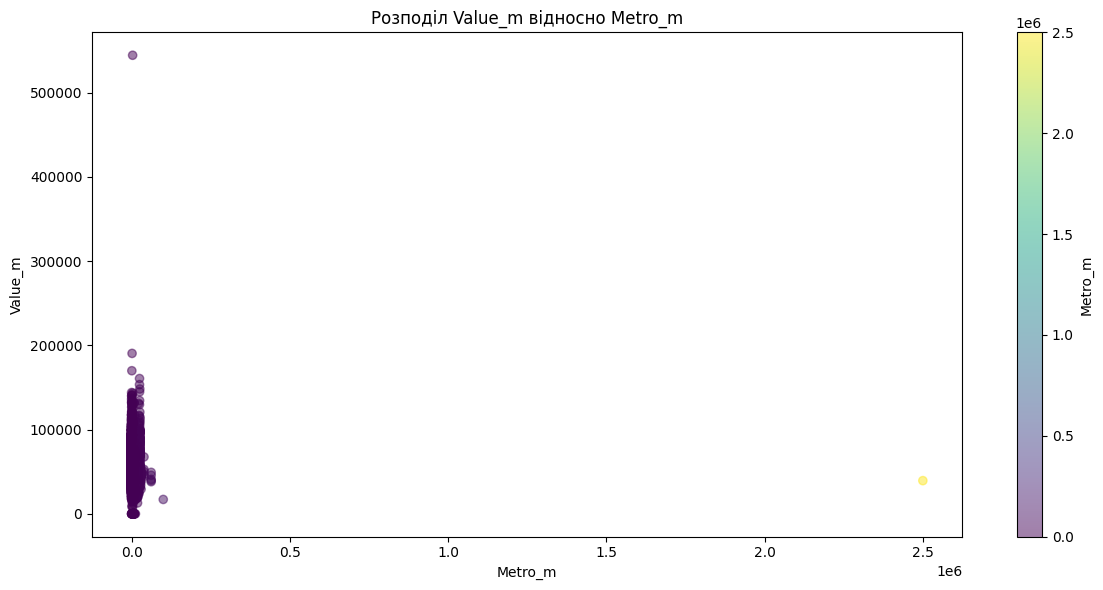

In [1229]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Metro_m'], df['Value_m'], c=df['Metro_m'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Metro_m')
plt.title('Розподіл Value_m відносно Metro_m')
plt.xlabel('Metro_m')
plt.ylabel('Value_m')
plt.tight_layout()
plt.show()

Замінимо всі значення більші за 30 км (це вже точно не в місті, напевно не валідні дані) - медіаною

In [1230]:
median_value = df['Metro_m'].median()
df['Metro_m'] = df['Metro_m'].apply(lambda x: median_value if x > 30000 else x)

Storeys, Space_Total, Space_Living, Space_Kitchen, Value_abs, Value_m, lat, Long - не можуть бути нульовими. Заміним нулі на медіанні значення.


In [1231]:
def replace_with_median(column):
    median_value = df[column].median()
    df[column] = df[column].apply(lambda x: median_value if x == 0 else x)

In [1232]:
for col in ["Storeys", "Space_Total", "Space_Living", "Space_Kitchen", "Value_abs", "Value_m", "lat", "Long"]:
    replace_with_median(col)


Видалим Long та Lat, так як Street та District більш релевантні для позначення розміщення.

In [1233]:
df = df.drop(columns=['Long', 'lat'])

Відшукаємо викиди та заповнимо їх медіаними значеннями

In [1234]:
def process_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_columns:
    df = process_outliers(col)

Проведем оцінку кореляції ознак

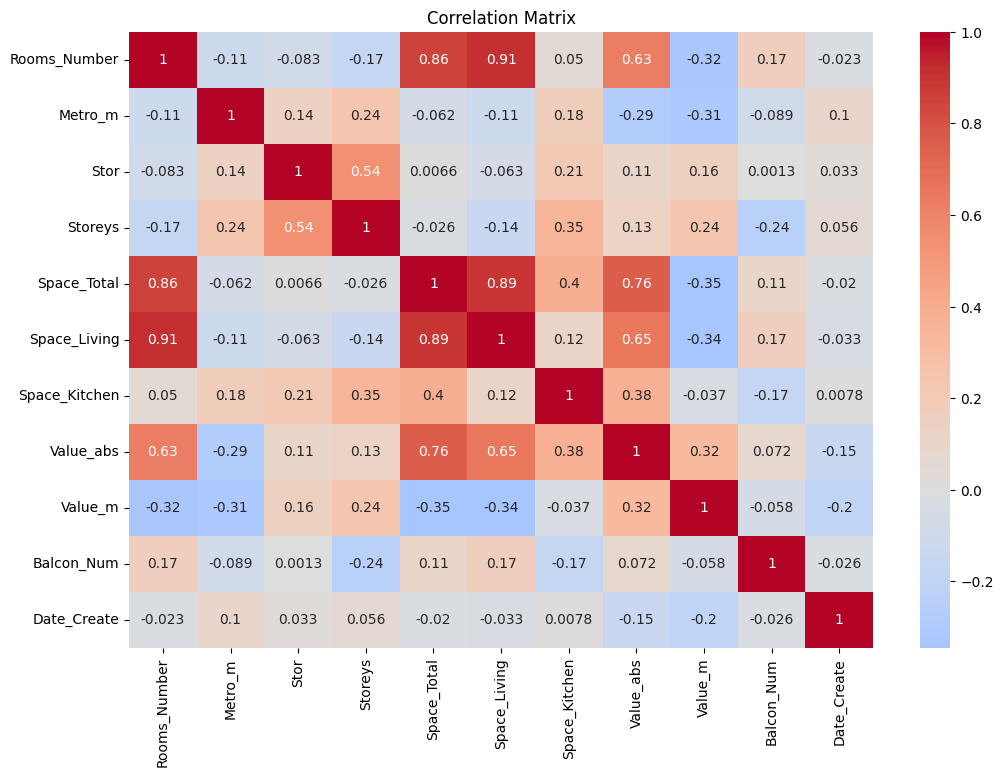

In [1235]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

Як ми бачимо присутній високий чтупінь кореляції між Space_Living, Space_Total та Rooms_Number. Space_Living можна сміливо видаляти - це є надмірна ознака з урахуванням наявності Space_Total та Rooms_Number. Rooms_Number можна було б теж видалити, але, на мою суб'єктивну думку, це є важливий параметер при оцінці житла і не завжди він так сильно корелює зі Space_Total, як в цьому датасеті. Тож все інше лишаємо.

In [1236]:
df = df.drop(columns=['Space_Living'])

Виконаємо one-hot encoding

In [1237]:
df = pd.get_dummies(df, drop_first=True)

###Висновки
На даному етапі ми провели аналіз всіх праметрів. Обробили пропуски. Позбулись аномальних значень, в тому числі викидів. Зменшили розмірність. Позбулись кореляції між параметрами.

##Етап 3
> Завдання: На основі підготовлених даних побудувати регресійні моделі:
KNN, Linear Regression та її модифікації, дерева рішень. Інтерпретувати
отримані результати. Порівняти отримані результати з тими, що були
отриманими першому етапі. Зробити висновки. Підготувати рекомендації
щодо покращення якості отриманих результатів.

Виконаємо тренування та оцінку моделей

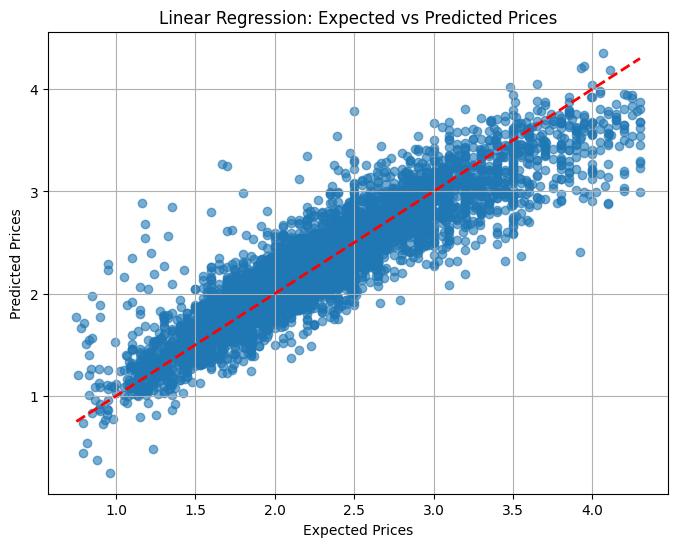

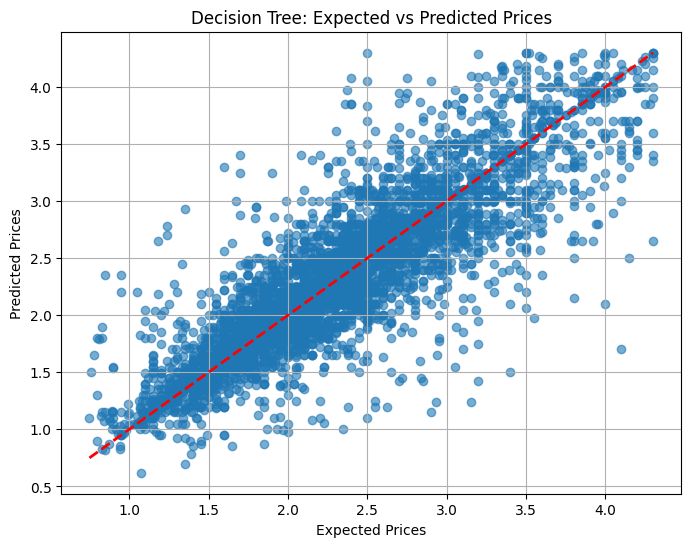

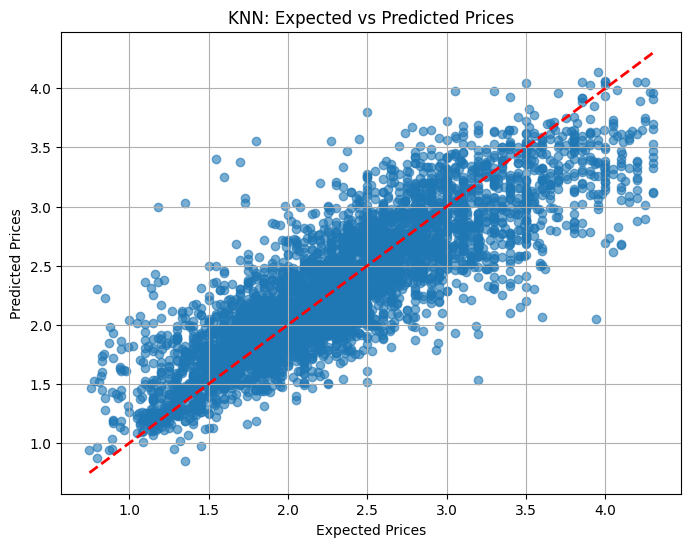


Results:
               Model            MAE           RMSE        R2
0  Linear Regression  214794.230487  289998.202265  0.821510
1      Decision Tree  238108.129749  359629.970310  0.725505
2                KNN  272557.264516  364620.628566  0.717834


In [1238]:
X = df.drop(columns=['Value_abs', 'Value_m'])
y = df['Value_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
train_and_evaluate()

###Висновки
Завдяки обробці даних ми змогли досягнути значно кращих результатів. Для порівняння, за метрикою MAE (що напевно є найбільш репрезентативною, так як показує середнє відхилення від істини) результати навіть кращі ніж в першій частині з використанням читерського Value_m (окрім дерева рішень, воно занадто добре користується витоком даних). Також бачимо що співвідношення MAE та RMSE нормалізувалось (позбулись викидів). Також значно зросла продуктивність.
Покращити результати можна за рахунок нормалізації даних. Нажаль тут її не реалізовано, так як застосування стандартної нормалізації призводило до значного погіршення роботи моделей. Треба провести додаткове дослідження. Напевно це все що можна зробити з цим набором даних. Для подальших покращень бажано зібрати більше різноманітних даних.